In [4]:
# Imports and setup
import os
import base64
import time
import json
import requests
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import yaml
from datetime import datetime, timedelta
import requests


# Load token
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
headers = {"Authorization": f"token {GITHUB_TOKEN}"}

In [15]:
!which python

/mnt/c/32Madjda/Prof/Stage/Benoit/rtool/github-actions-security-sandbox/.venv/bin/python


In [9]:
# Set organizations and discovery configuration
orgs = ["google", "microsoft", "facebook", "awslabs", "oracle", "intel", "ibm", "NVIDIA", "alibaba", "RedHatOfficial"]

min_stars = 2000
max_repos_per_org = 10  # Updated from 5 to 10

# Helper: check if last commit is recent (within 12 months)
def is_recent_commit(repo_full_name):
    commits_url = f"https://api.github.com/repos/{repo_full_name}/commits"
    params = {"per_page": 1}
    response = requests.get(commits_url, headers=headers, params=params)
    if response.status_code == 200 and response.json():
        latest_commit = response.json()[0]["commit"]["committer"]["date"]
        latest_date = datetime.strptime(latest_commit, "%Y-%m-%dT%H:%M:%SZ")
        return latest_date >= datetime.utcnow() - timedelta(days=365)
    return False

# Function to get top repos from a GitHub organization with filters
def get_top_repos(org, min_stars=2000, per_page=100):
    url = f"https://api.github.com/orgs/{org}/repos?per_page={per_page}&type=public"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        filtered = []
        for repo in data:
            if (
                not repo.get("archived", False)
                and repo.get("stargazers_count", 0) >= min_stars
            ):
                full_name = repo["full_name"]
                if is_recent_commit(full_name):
                    filtered.append(full_name)
            if len(filtered) >= max_repos_per_org:
                break
        return filtered
    else:
        print(f"Error fetching repos from {org}: {response.status_code}")
        return []

# Build full repository list from tech orgs
repositories = []
for org in orgs:
    repositories.extend(get_top_repos(org, min_stars))

# Replace old lists with the Top 50 most-starred public repositories on GitHub (as of mid-2025 snapshot)
top_starred_repos = [
    "freeCodeCamp/freeCodeCamp", "sindresorhus/awesome", "EbookFoundation/free-programming-books", "public-apis/public-apis", "jwasham/coding-interview-university", "vinta/awesome-python", "facebook/react", "vuejs/vue", "TheAlgorithms/Python", "trekhleb/javascript-algorithms", "tensorflow/tensorflow", "ossu/computer-science", "ohmyzsh/ohmyzsh", "Significant-Gravitas/AutoGPT", "microsoft/vscode", "twbs/bootstrap", "flutter/flutter", "github/gitignore", "AUTOMATIC1111/stable-diffusion-webui", "Snailclimb/JavaGuide", "airbnb/javascript", "avelino/awesome-go", "huggingface/transformers", "ollama/ollama", "ytdl-org/youtube-dl", "vercel/next.js", "f/awesome-chatgpt-prompts", "yangshun/tech-interview-handbook", "Chalarangelo/30-seconds-of-code", "Genymobile/scrcpy", "facebook/react-native", "microsoft/PowerToys", "electron/electron", "yt-dlp/yt-dlp", "krahets/hello-algo", "n8n-io/n8n", "nodejs/node", "d3/d3", "langchain-ai/langchain", "axios/axios", "mrdoob/three.js", "microsoft/TypeScript", "langgenius/dify", "rust-lang/rust", "denoland/deno", "facebook/create-react-app", "goldbergyoni/nodebestpractices", "excalidraw/excalidraw", "open-webui/open-webui", "microsoft/terminal"
]

repositories.extend(top_starred_repos)

print(f"Total selected repositories: {len(repositories)}")

/tmp/ipykernel_74067/941130584.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return latest_date >= datetime.utcnow() - timedelta(days=365)


Total selected repositories: 97


In [10]:
# Fetch .github/workflows/*.yml filenames for each repository
def fetch_workflows(repo_full_name):
    url = f"https://api.github.com/repos/{repo_full_name}/contents/.github/workflows"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return [item['name'] for item in data if item['type'] == 'file']
    else:
        print(f"Failed to fetch workflows for {repo_full_name}: {response.status_code}")
        return []

results = {}
for repo in repositories:
    results[repo] = fetch_workflows(repo)

# Save workflow list to CSV
os.makedirs("../dataset", exist_ok=True)
df = pd.DataFrame.from_dict(results, orient='index').transpose()
df.to_csv("../dataset/workflow_list.csv", index=False)
df.head()


Failed to fetch workflows for google/ios-webkit-debug-proxy: 404
Failed to fetch workflows for google/traceur-compiler: 404
Failed to fetch workflows for microsoft/plcrashreporter: 404
Failed to fetch workflows for microsoft/microsoft.github.io: 404
Failed to fetch workflows for microsoft/cpprestsdk: 404
Failed to fetch workflows for microsoft/dotnet: 404
Failed to fetch workflows for microsoft/referencesource: 404
Failed to fetch workflows for facebook/mysql-5.6: 404
Failed to fetch workflows for awslabs/amazon-redshift-utils: 404
Failed to fetch workflows for oracle/node-oracledb: 404
Failed to fetch workflows for oracle/visualvm: 404
Failed to fetch workflows for NVIDIA/nccl: 404
Failed to fetch workflows for NVIDIA/pix2pixHD: 404
Failed to fetch workflows for NVIDIA/cuda-samples: 404
Failed to fetch workflows for NVIDIA/apex: 404
Failed to fetch workflows for alibaba/canal: 404
Failed to fetch workflows for alibaba/weex: 404
Failed to fetch workflows for vinta/awesome-python: 404


,google/truth,google/dagger,google/ios-webkit-debug-proxy,google/traceur-compiler,google/auto,google/go-github,google/go-querystring,google/jimfs,google/blockly,google/grr,...,axios/axios,mrdoob/three.js,langgenius/dify,rust-lang/rust,denoland/deno,facebook/create-react-app,goldbergyoni/nodebestpractices,excalidraw/excalidraw,open-webui/open-webui,microsoft/terminal
0,ci.yml,ci.yml,None,None,ci.yml,linter.yml,linter.yml,ci.yml,appengine_deploy.yml,build.yml,...,ci.yml,ci.yml,api-tests.yml,ci.yml,cargo_publish.yml,build-and-test.yml,automerge-prs.yml,autorelease-excalidraw.yml,build-release.yml,addToProject.yml
1,None,release.yml,None,None,None,tests.yml,tests.yml,None,assign_reviewers.yml,publish-pypi.yml,...,codeql-analysis.yml,codeql-code-scanning.yml,build-push.yml,dependencies.yml,ci.generate.ts,e2e-base.yml,lint-and-generate-html-from-markdown.yml,autorelease-preview.yml,codespell.disabled,spelling2.yml
2,None,None,None,None,None,None,None,None,browser_test.yml,None,...,depsreview.yaml,read-size.yml,db-migration-test.yml,ghcr.yml,ci.yml,lint.yml,update-date-in-last-update-badge.yml,build-docker.yml,deploy-to-hf-spaces.yml,winget.yml
3,None,None,None,None,None,None,None,None,build.yml,None,...,labeler.yml,report-size.yml,deploy-dev.yml,post-merge.yml,node_compat_test.yml,None,update-last-update-badge.sh,cancel.yml,docker-build.yaml,None
4,None,None,None,None,None,None,None,None,conventional-label.yml,None,...,notify.yml,None,deploy-enterprise.yml,None,npm_publish.yml,None,None,lint.yml,format-backend.yaml,None


In [11]:
# Load previously fetched content if exists
fetched_path = Path("../dataset/fetched_workflows.pkl")
try:
    fetched_data = pd.read_pickle(fetched_path)
    print("Loaded existing progress.")
except FileNotFoundError:
    fetched_data = pd.DataFrame(columns=["repo", "workflow_file", "content"])
    print("Starting fresh.")


Loaded existing progress.


In [12]:
# Function to fetch base64-encoded workflow content
def fetch_workflow_content(repo, filename, retries=3, delay=3):
    url = f"https://api.github.com/repos/{repo}/contents/.github/workflows/{filename}"
    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                content = response.json().get('content')
                if content:
                    return base64.b64decode(content).decode('utf-8')
            elif response.status_code == 404:
                print(f"Not found: {repo}/{filename}")
                return None
            else:
                print(f"Error {response.status_code} for {repo}/{filename}")
        except requests.exceptions.RequestException as e:
            print(f"Retry {attempt+1}/{retries} failed: {e}")
            time.sleep(delay)
    print(f"All retries failed for {repo}/{filename}")
    return None


In [13]:
import yaml

def extract_trigger_events(yaml_data):
    if isinstance(yaml_data, dict):
        if 'on' in yaml_data:
            return yaml_data['on']
        elif True in yaml_data:  # PyYAML may convert 'on' to True
            return yaml_data[True]
    return None

# Extended fetched_data structure with metadata columns
fetched_data = pd.DataFrame(columns=[
    "repo", "workflow_file", "content",
    "loc", "num_jobs", "num_triggers", "trigger_types", "num_reused_actions"
])

count = 0
total = sum(len(v) for v in results.values())

# Iterate and fetch content + extract metadata
for repo, filenames in results.items():
    for filename in filenames:
        if ((fetched_data['repo'] == repo) & (fetched_data['workflow_file'] == filename)).any():
            continue

        content = fetch_workflow_content(repo, filename)

        if not filename.endswith((".yml", ".yaml")):
            continue

        # Clean content (e.g., replace tabs) before parsing
        content_cleaned = content.replace('\t', '    ')

        try:
            parsed = yaml.safe_load(content_cleaned)
        except Exception as e:
            print(f"YAML parse error in {repo}/{filename}: {e}")
            parsed = {}

        loc = len(content.splitlines())
        jobs = parsed.get("jobs", {})

        # Extract trigger list using safe fallback logic
        raw_triggers = extract_trigger_events(parsed)

        if isinstance(raw_triggers, str):
            trigger_list = [raw_triggers]
        elif isinstance(raw_triggers, list):
            trigger_list = raw_triggers
        elif isinstance(raw_triggers, dict):
            trigger_list = list(raw_triggers.keys())
        else:
            trigger_list = []

        uses_count = content.count("uses:")

        # Store all metadata
        fetched_data = pd.concat([fetched_data, pd.DataFrame({
            "repo": [repo],
            "workflow_file": [filename],
            "content": [content],
            "loc": [loc],
            "num_jobs": [len(jobs)],
            "num_triggers": [len(trigger_list)],
            "trigger_types": [", ".join(trigger_list)],
            "num_reused_actions": [uses_count]
        })], ignore_index=True)

        count += 1
        if count % 50 == 0:
            fetched_data.to_pickle(fetched_path)
            print(f"Progress saved: {count}/{total} files processed")

# Final save
fetched_data.to_pickle(fetched_path)
print("All workflow contents and metadata fetched and saved.")


Progress saved: 50/614 files processed
Progress saved: 100/614 files processed
Progress saved: 150/614 files processed
Progress saved: 200/614 files processed
Progress saved: 250/614 files processed
Progress saved: 300/614 files processed
Progress saved: 350/614 files processed
Progress saved: 400/614 files processed
Progress saved: 450/614 files processed
Progress saved: 500/614 files processed
Progress saved: 550/614 files processed
All workflow contents and metadata fetched and saved.


In [16]:
df = pd.read_pickle("../dataset/fetched_workflows.pkl")
df.to_csv("../dataset/workflow_metadata.csv", index=False)
df.drop(columns=["content"]).to_csv("../dataset/workflow_metadata_no-content.csv", index=False)
print("Exported to ../dataset/workflow_metadata.csv")

Exported to ../dataset/workflow_metadata.csv


In [32]:
# Export all fetched contents to raw_workflows folder
output_dir = Path("../raw_workflows")
output_dir.mkdir(parents=True, exist_ok=True)

for _, row in fetched_data.iterrows():
    if not row["content"]:
        continue
    repo_clean = row['repo'].replace('/', '_')
    filename = f"{repo_clean}__{row['workflow_file']}"
    with open(output_dir / filename, "w", encoding="utf-8") as f:
        f.write(row["content"])

print("Export complete. All files saved to ../raw_workflows/")


Export complete. All files saved to ../raw_workflows/


24 workflows added from [step-security/github-actions-goat](https://github.com/step-security/github-actions-goat/tree/main/.github/workflows) — known as **vulnerable workflows**.
# Blog-confirmed vulnerable repositories
blog_repos = ["liquibase/liquibase", "DynamoDS/Dynamo", "fauna/faunadb", "wireapp/wire", "withastro/astro", "kiegroup/kogito-runtimes", "tidusjar/Ombi", "argoproj/argo-workflows", "gitpod-io/gitpod", "openfaas/faas", "OWASP/defectdojo", "aquasecurity/trivy", "google/osv-scanner", "dagster-io/dagster"]

In [1]:
import matplotlib.pyplot as plt


In [38]:
import numpy
print(numpy.__file__)


/mnt/c/32Madjda/Prof/Stage/Benoit/rtool/github-actions-security-sandbox/.venv/lib/python3.12/site-packages/numpy/__init__.py


In [17]:
import pandas as pd

# Load dataset
df = pd.read_csv("../dataset/workflow_metadata.csv")

# Ensure numeric columns are properly typed
numeric_cols = ["loc", "num_jobs", "num_triggers", "num_reused_actions"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Generate summary statistics
summary = {
    "Total workflows (.yml/.yaml files)": len(df),
    "Unique repositories (distinct GitHub projects)": df["repo"].nunique(),
    "Lines of code per workflow (median size)": f"{int(df['loc'].median())} ({df['loc'].min()} - {df['loc'].max()})",
    "Jobs per workflow (median size)": f"{int(df['num_jobs'].median())} ({df['num_jobs'].min()} - {df['num_jobs'].max()})",
    "Trigger types per workflow (median size)": f"{int(df['num_triggers'].median())} ({df['num_triggers'].min()} - {df['num_triggers'].max()})",
    "Reused Actions (median size)": f"{int(df['num_reused_actions'].median())} ({df['num_reused_actions'].min()} - {df['num_reused_actions'].max()})"
}

# Create display table
summary_df = pd.DataFrame(summary.items(), columns=["Metric", "Value (min - max)"])
summary_df


,Metric,Value (min - max)
0,Total workflows (.yml/.yaml files),596
1,Unique repositories (distinct GitHub projects),77
2,Lines of code per workflow (median size),55 (11 - 916)
3,Jobs per workflow (median size),1 (1 - 41)
4,Trigger types per workflow (median size),1 (1 - 4)
5,Reused Actions (median size),3 (0 - 115)


In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../dataset/workflow_metadata.csv")

# Ensure numeric columns
df["loc"] = pd.to_numeric(df["loc"], errors="coerce")
df["num_reused_actions"] = pd.to_numeric(df["num_reused_actions"], errors="coerce")

# Apply updated filters: LOC between 15 and 20, and at least 1 reused action
filtered_df = df[(df["loc"] == 28) & (df["num_reused_actions"] >= 1)]

# Return relevant columns
result = filtered_df[["repo", "workflow_file", "loc", "num_jobs", "num_triggers","num_reused_actions"]]

# Print the results
print("Matching workflows (LOC 15–20 and at least 1 reused action):\n")
print(result.to_string(index=False))


Matching workflows (LOC 15–20 and at least 1 reused action):

                   repo               workflow_file  loc  num_jobs  num_triggers  num_reused_actions
public-apis/public-apis          validate_links.yml   28         1             2                   2
        flutter/flutter                  mirror.yml   28         1             1                   1
  facebook/react-native      generate-changelog.yml   28         1             1                   3
  facebook/react-native         needs-attention.yml   28         1             1                   2
  facebook/react-native publish-bumped-packages.yml   28         1             1                   3
        langgenius/dify          deploy-rag-dev.yml   28         1             1                   1
  excalidraw/excalidraw              size-limit.yml   28         1             1                   3


In [19]:
df = pd.read_csv("../dataset/workflow_metadata.csv")

# Extract all 'uses:' actions from content (only keep valid non-null entries)
df = df[df["content"].notnull()]
actions = df["content"].str.extractall(r'uses:\s*["\']?([\w\-/\.@]+)["\']?')[0]
actions.name = "action"
actions = actions.reset_index().merge(df[["repo"]], left_on="level_0", right_index=True)

# Compute frequency stats
action_counts = actions["action"].value_counts().reset_index()
action_counts.columns = ["action", "count_steps"]

# Compute repository coverage: number of unique repos using each action
repo_action = actions.drop_duplicates(subset=["repo", "action"])
repo_counts = repo_action["action"].value_counts().reset_index()
repo_counts.columns = ["action", "count_repos"]

# Merge and calculate percentages
merged = pd.merge(action_counts, repo_counts, on="action")
total_steps = len(actions)
total_repos = df["repo"].nunique()
merged["% steps"] = (merged["count_steps"] / total_steps * 100).round(1)
merged["% repositories"] = (merged["count_repos"] / total_repos * 100).round(1)

# Keep top 10
top_10 = merged[["action", "% steps", "% repositories"]].head(10)
top_10

,action,% steps,% repositories
0,actions/checkout@v4,15.4,58.4
1,actions/cache/restore@v4,7.8,10.4
2,actions/cache/save@v4,7.4,10.4
3,actions/checkout@11bd71901bbe5b1630ceea73d2759...,4.7,19.5
4,actions/upload-artifact@v4,4.4,35.1
5,actions/setup-node@v4,3.4,26.0
6,actions/download-artifact@v4,3.0,20.8
7,actions/setup-node@49933ea5288caeca8642d1e84af...,2.3,7.8
8,actions/cache@v4,2.1,16.9
9,actions/setup-python@v5,1.8,20.8


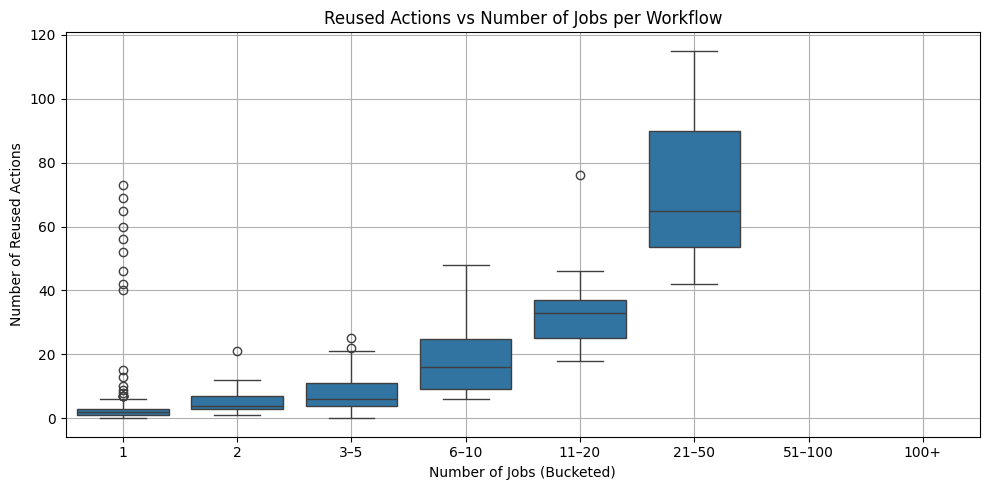

In [28]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("../dataset/workflow_metadata.csv")
df["num_jobs"] = pd.to_numeric(df["num_jobs"], errors="coerce")
df["num_reused_actions"] = pd.to_numeric(df["num_reused_actions"], errors="coerce")

# Filter out bad data
df = df.dropna(subset=["num_jobs", "num_reused_actions"])

# Create a boxplot of reused actions by number of jobs (bucketed)
df["job_bucket"] = pd.cut(df["num_jobs"],
    bins=[0, 1, 2, 5, 10, 20, 50, 100, float("inf")],
    labels=["1", "2", "3–5", "6–10", "11–20", "21–50", "51–100", "100+"]
)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="job_bucket", y="num_reused_actions")
plt.title("Reused Actions vs Number of Jobs per Workflow")
plt.xlabel("Number of Jobs (Bucketed)")
plt.ylabel("Number of Reused Actions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("../dataset/workflow_metadata.csv")
df["num_jobs"] = pd.to_numeric(df["num_jobs"], errors="coerce")
df["num_reused_actions"] = pd.to_numeric(df["num_reused_actions"], errors="coerce")

# Define thresholds
job_threshold = 1
action_threshold = 5

# Categorize workflows
def categorize(row):
    if row["num_jobs"] <= job_threshold and row["num_reused_actions"] <= action_threshold:
        return "1 job, ≤ 5 actions"
    elif row["num_jobs"] > job_threshold and row["num_reused_actions"] <= action_threshold:
        return ">1 job, ≤ 5 actions"
    elif row["num_jobs"] <= job_threshold and row["num_reused_actions"] > action_threshold:
        return "1 job, > 5 actions"
    else:
        return ">1 job, > 5 actions"

df["complexity_group"] = df.apply(categorize, axis=1)

# Count and compute percentages
summary = df["complexity_group"].value_counts().rename_axis("Complexity Group").reset_index(name="# of Workflows")
summary["% of Dataset"] = (summary["# of Workflows"] / len(df) * 100).round(1)

summary = pd.concat([summary], ignore_index=True)

# Display the table
summary


,Complexity Group,# of Workflows,% of Dataset
0,"1 job, ≤ 5 actions",402,67.4
1,">1 job, > 5 actions",96,16.1
2,">1 job, ≤ 5 actions",71,11.9
3,"1 job, > 5 actions",27,4.5


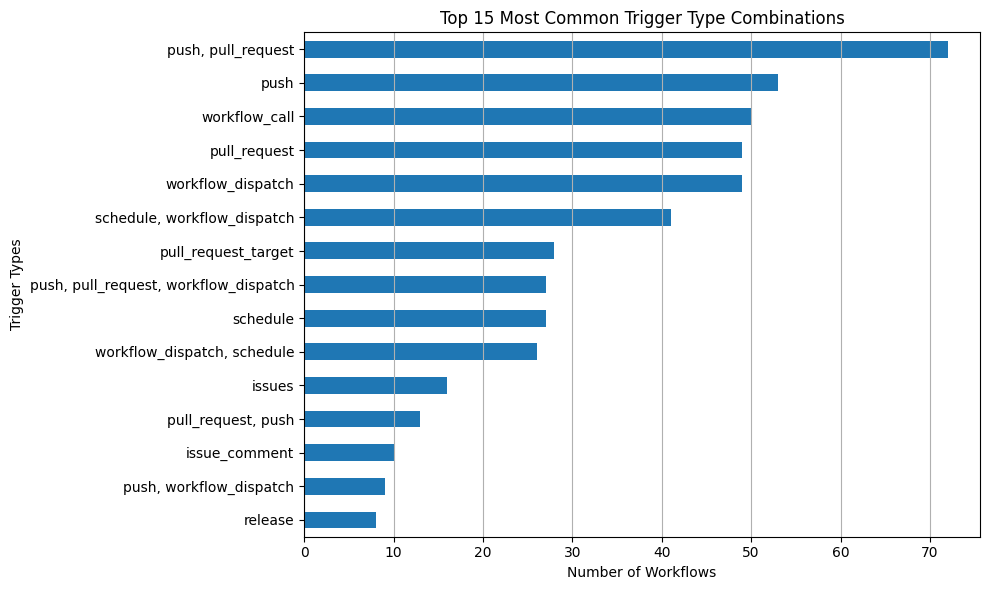

In [23]:
#Plot 4: Top 15 most common trigger types combinations
plt.figure(figsize=(10, 6))
df['trigger_types'].value_counts().head(15).plot(kind='barh')
plt.title("Top 15 Most Common Trigger Type Combinations")
plt.xlabel("Number of Workflows")
plt.ylabel("Trigger Types")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("../dataset/workflow_metadata.csv")

# Ensure numeric values
df["num_reused_actions"] = pd.to_numeric(df["num_reused_actions"], errors="coerce")

# Total number of reused actions in all workflows
total_reused_actions = df["num_reused_actions"].sum()

# Number of workflows that have at least one reused action
workflows_with_reused_actions = (df["num_reused_actions"] > 0).sum()

print(f"Total reused actions across all workflows: {total_reused_actions}")
print(f"Number of workflows with at least one reused action: {workflows_with_reused_actions}")


Total reused actions across all workflows: 3385
Number of workflows with at least one reused action: 576
